In [1]:
import pyipn
from pyipn.io import import_lc
from pyipn import copy_template, Universe

import h5py
from astropy.time import Time, TimeDelta
import datetime as dt
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
with h5py.File("/home/msinghart/data/lc/GBM_TRIGDAT/gbm_trigdat.hdf5", 'r') as gbm:
    with h5py.File("/home/msinghart/data/lc/INTEGRAL_SPIACS/integral_spiacs.hdf5", 'r') as integral:
        close = []
        for grp_gbm_name in gbm:
            grp_gbm = gbm[grp_gbm_name]
            trigtime_gbm = Time.strptime(grp_gbm.attrs['trigtime'], '%Y-%m-%d_%H:%M:%S.%f')
            for grp_integral_name in integral:
                grp_integral = integral[grp_integral_name]
                trigtime_integral = Time.strptime(grp_integral.attrs['trigtime'], '%Y-%m-%d_%H:%M:%S.%f')
                delta = (trigtime_gbm - trigtime_integral).to_datetime()
                if abs(delta.total_seconds()) < 10.:
                    gbm_dict = {'trigtime': trigtime_gbm,
                          'time': grp_gbm['time'].value,
                          'rate': grp_gbm['rate'].value,
                          'combinedchannels': grp_gbm['combinedchannels'].value,
                          'binsize': grp_gbm['binsize'].value,
                          'position': grp_gbm['position'].value
                          }
                    integral_dict = {'trigtime': trigtime_integral,
                               'time': grp_integral['time'].value,
                               'count': grp_integral['count'].value}
                    close.append([delta, gbm_dict, integral_dict])
               
        #print(close)

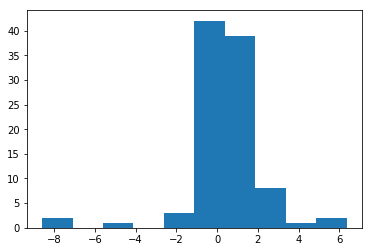

In [3]:
timediff = []
for elem in close:
    timediff.append(elem[0].total_seconds())

timediff =np.array(timediff)
hist, bins = np.histogram(timediff)

plt.hist(timediff)
plt.show()

In [4]:

tle_G = 'GLAST2018-01-01 00:00:00--2018-12-31 00:00:00_tle.txt'
tle_I = 'INTEGRAL2018-01-01 00:00:00--2018-12-31 00:00:00_tle.txt'

Using cached StanModel


<IPython.core.display.Javascript object>


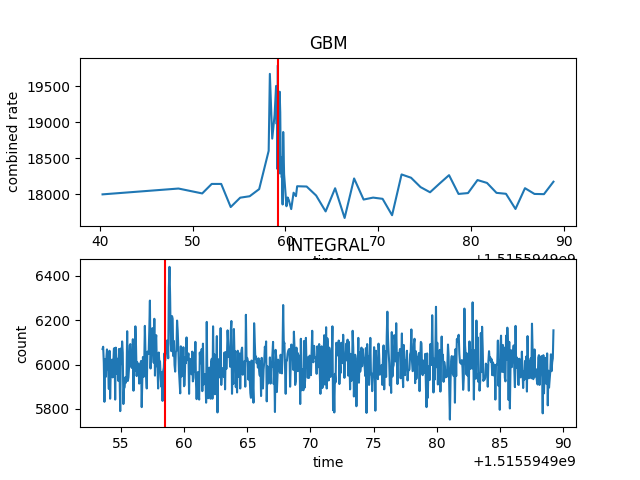

<IPython.core.display.Javascript object>


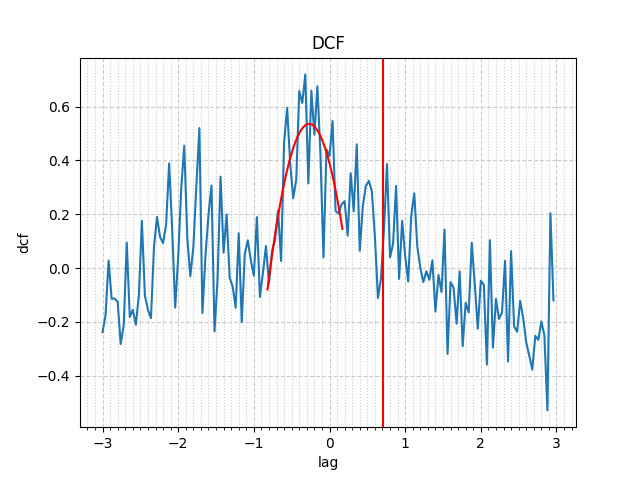

1/98
-0.3199999999999976
2018-01-10 14:35:59.218000
-0.5376725055421755


<IPython.core.display.Javascript object>


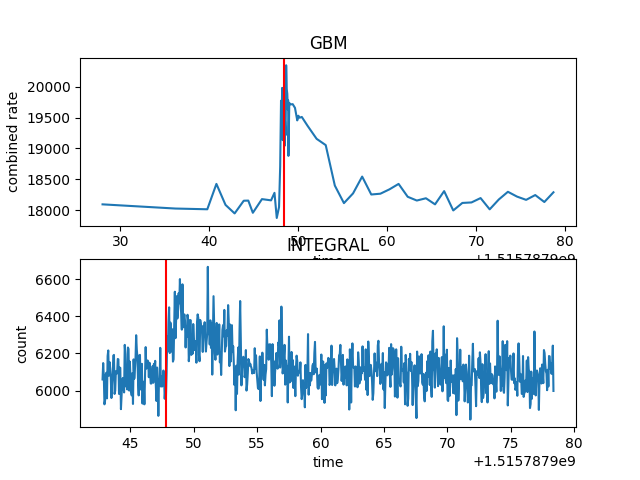

<IPython.core.display.Javascript object>


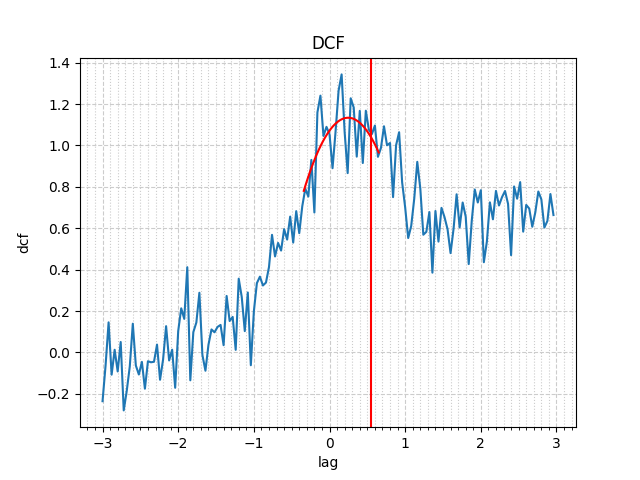

2/98
0.1600000000000028
2018-01-12 20:12:28.340000
0.49203000660521473


<IPython.core.display.Javascript object>


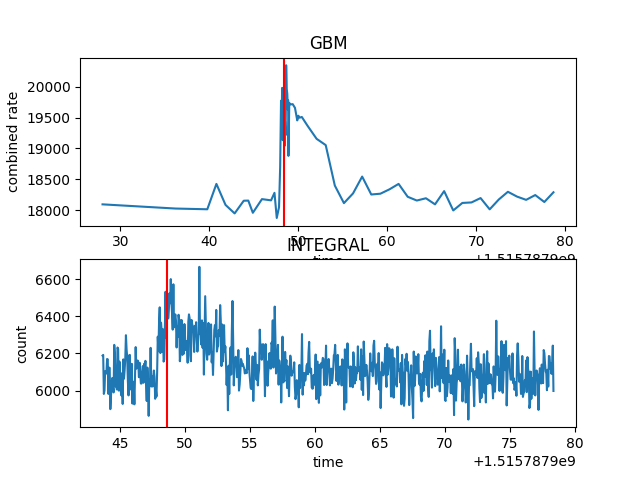

<IPython.core.display.Javascript object>


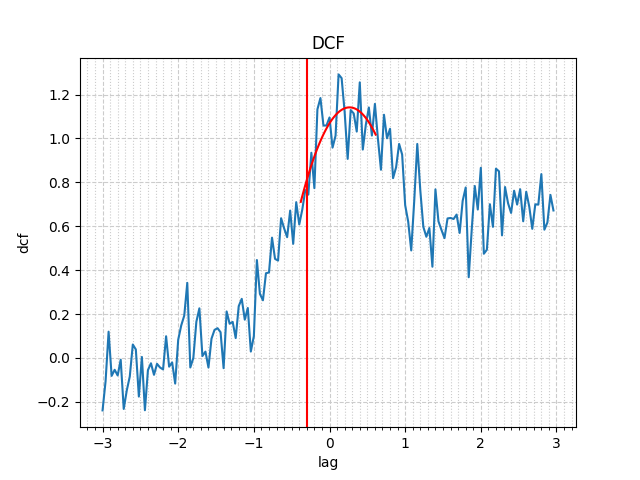

3/98
0.12000000000000277
2018-01-12 20:12:28.340000
0.5284494793901754


<IPython.core.display.Javascript object>


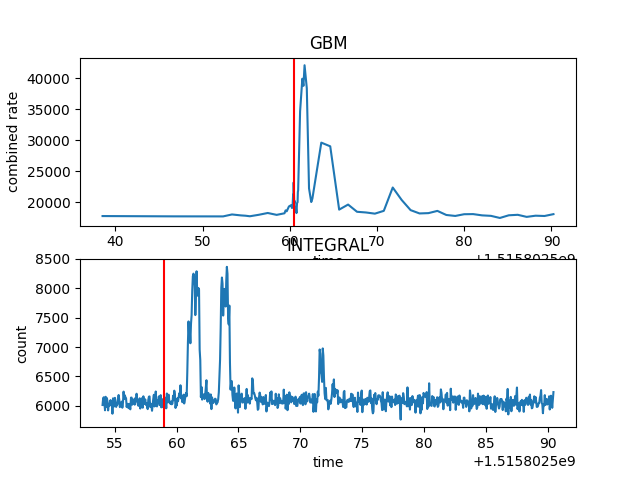

<IPython.core.display.Javascript object>


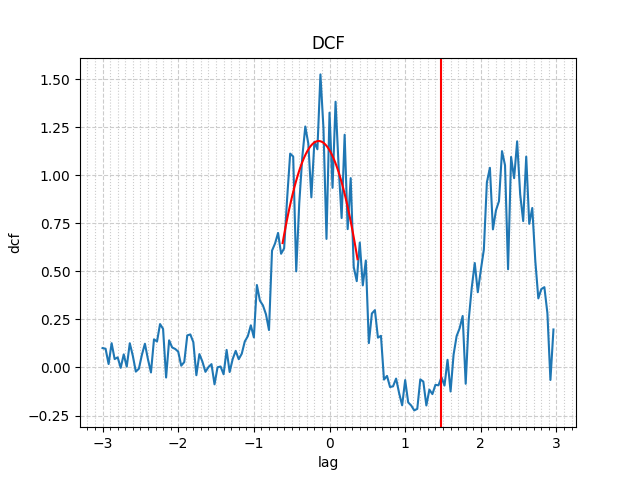

4/98
-0.11999999999999744
2018-01-13 00:16:00.471000
-0.2862826828139069


<IPython.core.display.Javascript object>


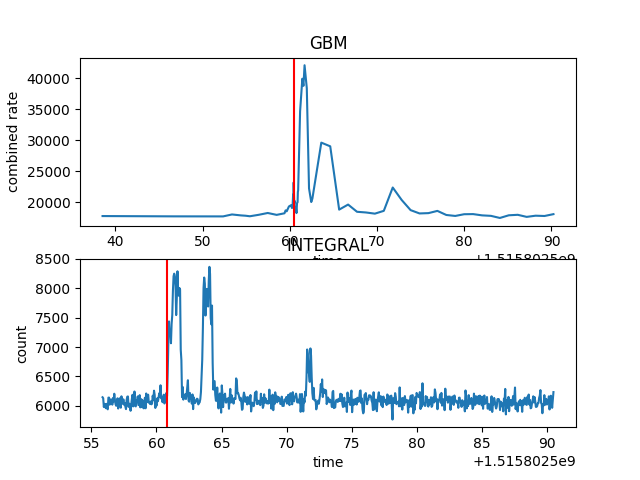

<IPython.core.display.Javascript object>


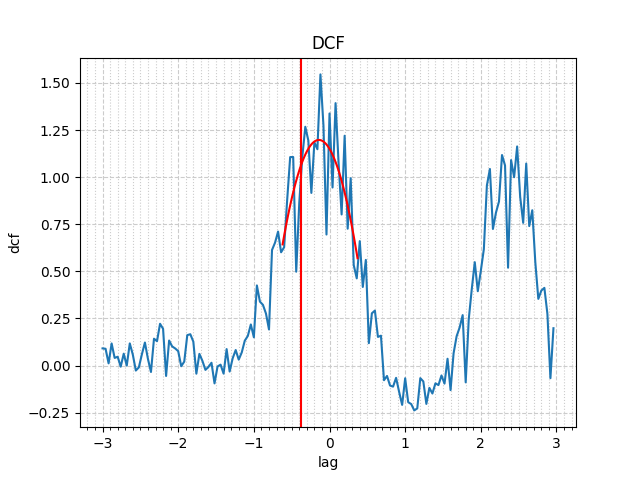

5/98
-0.11999999999999744
2018-01-13 00:16:00.471000
-0.2807164015172937


<IPython.core.display.Javascript object>


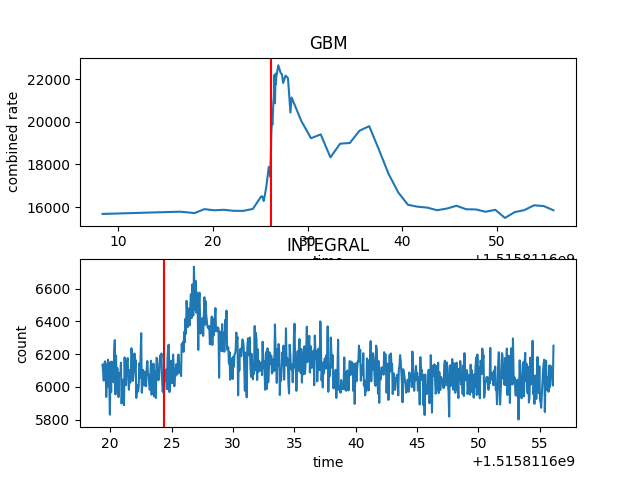

<IPython.core.display.Javascript object>


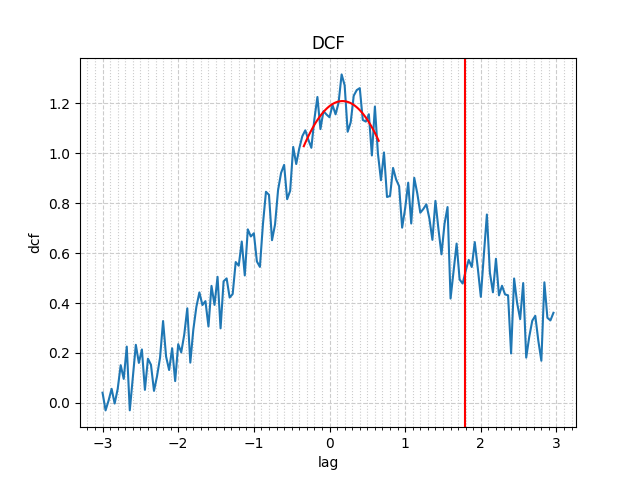

6/98
0.1600000000000028
2018-01-13 02:47:06.136000
0.34187347032536963


<IPython.core.display.Javascript object>


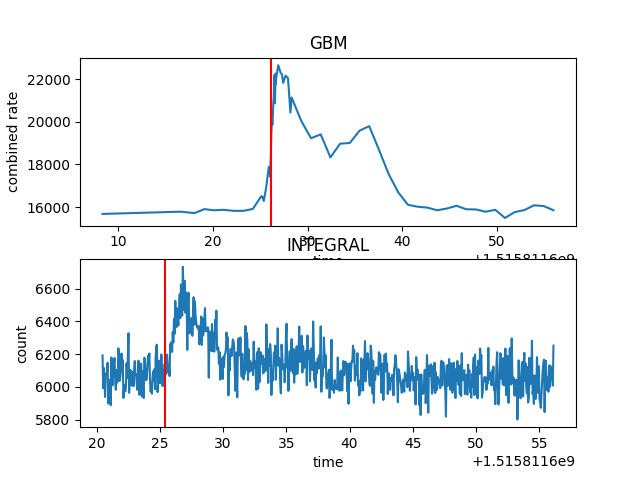

<IPython.core.display.Javascript object>


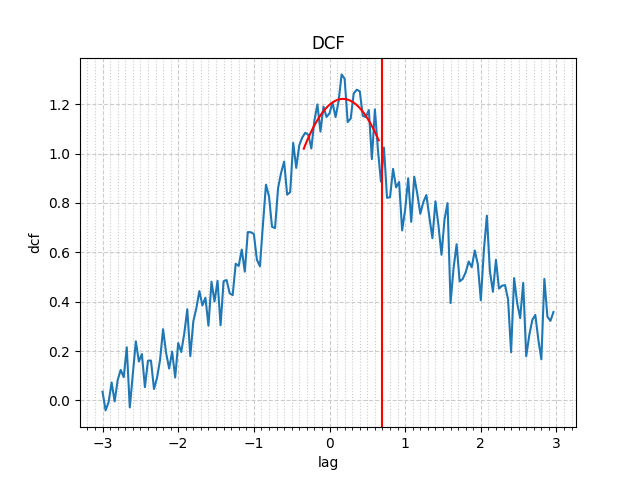

7/98
0.1600000000000028
2018-01-13 02:47:06.136000
0.35570251859237856


<IPython.core.display.Javascript object>


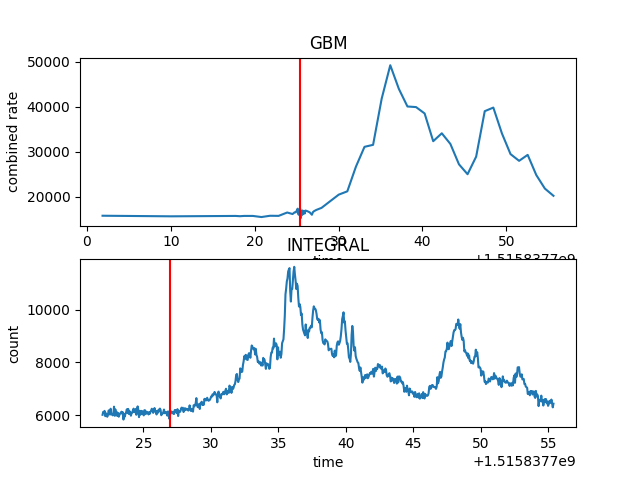

<IPython.core.display.Javascript object>


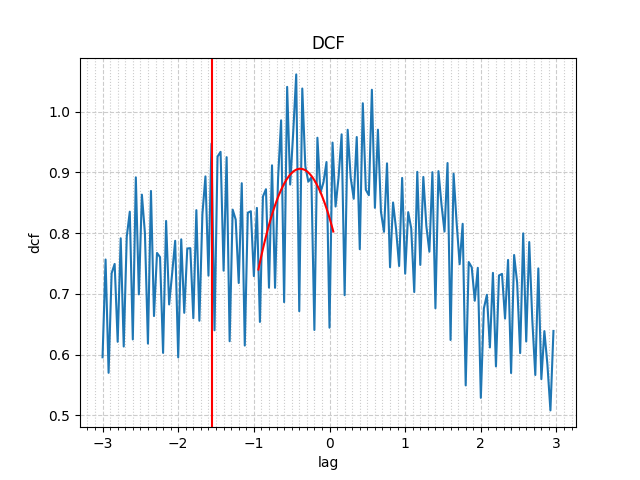

8/98
-0.4399999999999977
2018-01-13 10:02:05.407000
-0.7734397367480484


<IPython.core.display.Javascript object>


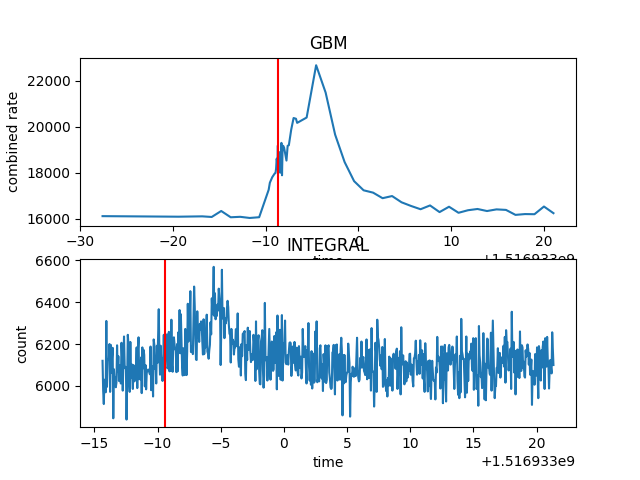

<IPython.core.display.Javascript object>


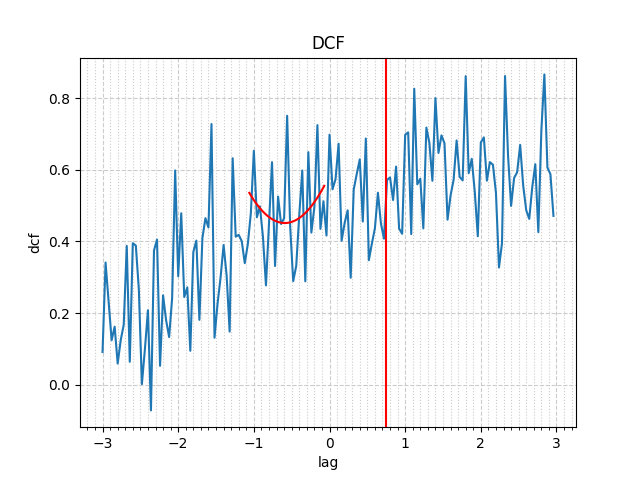

9/98
2.840000000000005
2018-01-26 02:16:31.363000
-1.1817372129914159


<IPython.core.display.Javascript object>


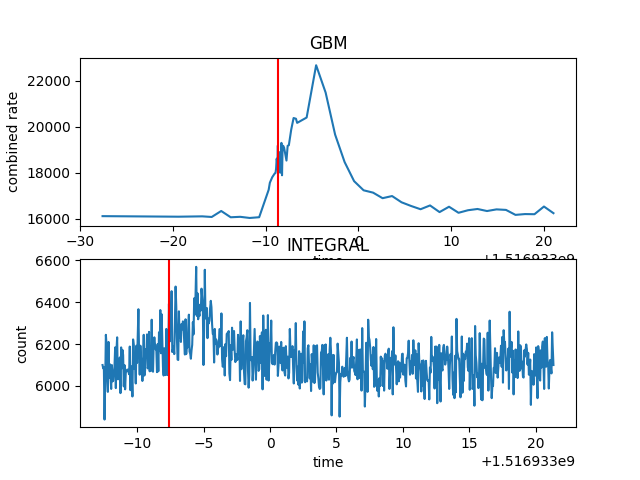

<IPython.core.display.Javascript object>


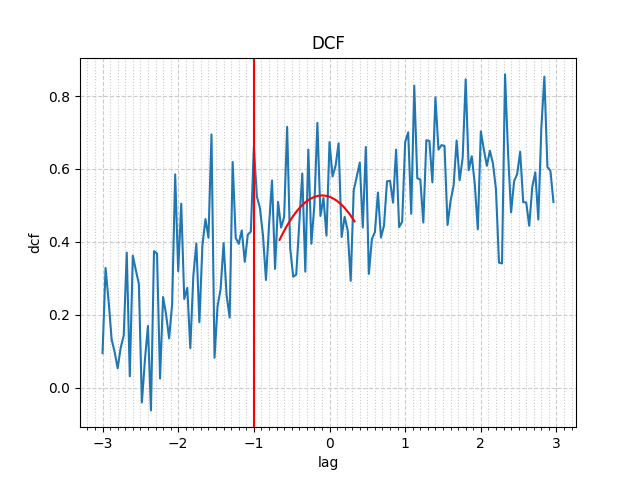

10/98
2.3200000000000047
2018-01-26 02:16:31.363000
-0.19682757089121736


In [23]:
import pyipn.cc
import stan_utility
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

model = stan_utility.compile_model('/home/msinghart/pyipn/prototype/rff.stan', model_name='rff')

np.set_printoptions(threshold=np.inf, precision=16)
j = 0
fits = []
for elem in close[0:10]:
    j += 1
    gbm = elem[1]
    integral = elem[2]
    trigtime_gbm = gbm['trigtime']
    trigtime_int = integral['trigtime']
    time_gbm = gbm['time']
    time_int = integral['time']
    rate_gbm = np.sum(gbm['combinedchannels'], axis=0)
    count_int = integral['count']
    binsize_gbm = gbm['binsize']
    binsize_int = np.zeros(time_int.size)+0.05
    
    relevant_gbm = np.where(abs(time_gbm - trigtime_gbm.unix) <= 30.)
    re_binsize_gbm = binsize_gbm[relevant_gbm]
    re_time_gbm = time_gbm[relevant_gbm]+0.5*re_binsize_gbm    
    re_rate_gbm = rate_gbm[relevant_gbm]
    
    re_time_gbm_sort = np.argsort(re_time_gbm)
    re_binsize_gbm = re_binsize_gbm[re_time_gbm_sort]
    re_time_gbm = re_time_gbm[re_time_gbm_sort]
    re_rate_gbm = re_rate_gbm[re_time_gbm_sort]
    
    relevant_int = np.where(abs(time_int - trigtime_gbm.unix) <= 30.)
    re_binsize_int = binsize_int[relevant_int]
    re_time_int = time_int[relevant_int]+0.5*re_binsize_int
    re_count_int = count_int[relevant_int]
    
    #print(trigtime_gbm)
    #print(time_gbm)
    #print(binsize_gbm)
    #print(rate_gbm)
    
    fig, axs = plt.subplots(2)
    axs[0].plot(re_time_gbm, re_rate_gbm)
    axs[0].axvline(x=trigtime_gbm.unix, color='red')
    axs[0].set_title('GBM')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('combined rate')
    
    axs[1].plot(re_time_int, re_count_int)
    axs[1].axvline(x=trigtime_int.unix, color='red')
    axs[1].set_title('INTEGRAL')
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('count')
    
    uccf, lags = pyipn.cc.uccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int)
    
#     axs[1, 0].scatter(lags, uccf, marker=',', s=1)
#     axs[1, 0].set_title('UCCF')
#     axs[1, 0].set_xlabel('time')
#     axs[1, 0].set_ylabel('uccf')

    minimum = -3.
    maximum = 3.
    timediff = .04

    bins, dcf, sigma_dcf = pyipn.cc.dcf(uccf, lags, start=minimum, stop=maximum, step=timediff)
    
    center_bins = bins[np.where((bins >= -1.) & (bins <= 1.))]
    center_dcf = dcf[np.where((bins >= -1.) & (bins <= 1.))]
    argmax = center_bins[np.argmax(center_dcf)]
    
    size = 0.5
    sup_cent_bins = center_bins[np.where((center_bins >= argmax-size) & (center_bins <= argmax+size))]
    sup_cent_dcf = center_dcf[np.where((center_bins >= argmax-size) & (center_bins <= argmax+size))]
    
    parab = np.polyfit(sup_cent_bins, sup_cent_dcf, 2)
    maxim = -parab[1]/parab[0]
    
    trange = np.arange(argmax-size, argmax+size, 0.01)
    parab_t = np.poly1d(parab)(trange)
    
    fig1, axs1 = plt.subplots()
    axs1.plot(bins, dcf)
    axs1.plot(trange, parab_t, color='red')
    axs1.axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
    axs1.set_title('DCF')
    axs1.set_xlabel('lag')
    axs1.set_ylabel('dcf')
    axs1.xaxis.set_major_locator(MultipleLocator(1.))
    axs1.xaxis.set_minor_locator(AutoMinorLocator(10))
    axs1.grid(which='major', color='#CCCCCC', linestyle='--')
    axs1.grid(which='minor', color='#CCCCCC', linestyle=':')
    
    print(str(j)+'/'+str(len(close)))
    print(bins[np.argmax(dcf)])
    print(trigtime_gbm.datetime)
    print(maxim)

#     lnbins, lndcf, sigma_lndcf = pyipn.cc.lndcf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, lags, start=minimum, stop=maximum, step=timediff)
    
#     fig1, axs1 = plt.subplots()
#     axs1.plot(lnbins, lndcf)
#     axs1.axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs1.set_title('LNDCF')
#     axs1.set_xlabel('lag')
#     axs1.set_ylabel('lndcf')
#     axs1.xaxis.set_major_locator(MultipleLocator(1.))
#     axs1.xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs1.grid(which='major', color='#CCCCCC', linestyle='--')
#     axs1.grid(which='minor', color='#CCCCCC', linestyle=':')
    
#     print(str(j)+'/'+str(len(close)))
#     print(lnbins[np.argmax(lndcf)])
    
    
#     k=50
#     N_model = 300
#     omega=np.random.randn(k)
#     predict_time = np.linspace((trigtime_gbm.unix-30.) ,(trigtime_gbm.unix+30.) ,N_model)
    
#     data = dict(N1=len(re_rate_gbm),
#             time1=re_time_gbm,
#             counts1=re_rate_gbm.astype(int),
#             exposure1=re_binsize_gbm,
#             exposure2=re_binsize_int,
#             N2=len(re_count_int),
#             time2=re_time_int,
#             counts2=re_count_int.astype(int),
#             k=k,
#             bw=.7,
#             omega=omega,
#             N_model=N_model,
#             predict_time=predict_time
           
           
           
#            )
    
#     fit = model.sampling(warmup=200,iter=400,data=data, chains=4, seed=1234,
#                      control = dict(max_treedepth=15, adapt_delta=.9)
                    

#                     )
        
#     fits.append(fit)
    

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt

for fit in fits:
    #print(fit.stansummary())
    with plt.style.context('bmh'):
        fit.plot(['beta1','beta2',
              'dt',
              'log_amplitude1',
               'log_amplitude2',
             ]);
        fig, ax = plt.subplots()

        predict = fit.extract('predict')['predict']
        predict_time = fit.data['predict_time']


        for p in predict:

            ax.plot(predict_time,p, alpha=0.01)